In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import json
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input, Reshape, dot
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adamax, Adagrad
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Data Preprocessing

In [32]:
movie_data = pd.read_csv('ml-20m/movies.csv')
movie_data.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [33]:
rating_data = pd.read_csv('ml-20m/ratings.csv')
rating_data.head(5)

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [34]:
rating_data['userId'].isnull().any()

False

In [35]:
rating_data['movieId'].isnull().any()

False

In [36]:
rating_data['rating'].isnull().any()

False

In [37]:
noOfUniqueUsers = len(rating_data['userId'].unique())
noOfUniqueMovies = len(rating_data['movieId'].unique())
print(noOfUniqueUsers, noOfUniqueMovies)

138493 26744


In [38]:
userId = sorted(list(rating_data['userId'].unique()))
movieId = sorted(list(rating_data['movieId'].unique()))

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
train, test = train_test_split(rating_data, test_size = 0.2)

In [41]:
train.head()

,userId,movieId,rating,timestamp
15042419,103886,586,3.0,1012264679
7273947,50202,494,1.0,1094785413
9675554,66911,8542,4.0,1248287061
10099558,69850,377,4.0,941463832
7104637,49001,784,3.5,1162323111


# Model Definition

In [42]:
d_embeddings = 30
bias = 1

def create_model():
    movie = Input(shape = [1], name = 'movie')
    movieEmbedding = Embedding(noOfUniqueMovies+1, d_embeddings, name = 'Movie_Embedding')(movie)
    movieBias = Embedding(noOfUniqueMovies + 1, bias, name="Movie_Bias")(movie)
    user = Input(shape = [1], name = 'user')
    
    userEmbedding = Embedding(noOfUniqueUsers+1, d_embeddings, name = 'User_Embedding')(user)
    userBias = Embedding(noOfUniqueUsers + 1, bias, name="User_Bias")(user)

    utilityMatrix = multiply([movieEmbedding, userEmbedding])

    inputs = concatenate([utilityMatrix, userBias, movieBias])
    inputs = Flatten()(inputs)

    layer_1 = Dense(50, activation="relu", name = "Dense_Layer1")(inputs)
    layer_1 = Dropout(0.2)(layer_1)
    #layer_2 = Dense(100, activation="relu", name = "Dense_layer2")(layer_1)
    #layer_2 = Dropout(0.2)(layer_2)
    output = Dense(1, activation="relu", name = "output")(layer_1)
    model = Model(inputs = [movie, user], outputs = output)
    return model

In [43]:
rec_model = create_model()

In [44]:
rec_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie_Embedding (Embedding)     (None, 1, 30)        802350      movie[0][0]                      
__________________________________________________________________________________________________
User_Embedding (Embedding)      (None, 1, 30)        4154820     user[0][0]                       
__________________________________________________________________________________________________
multiply_2

## Model Training

In [45]:
if(not os.path.isfile("rec_model.h5")):
    print("Creating new model.")
    rec_model.compile(optimizer = Adam(lr = 0.001), loss = ['mse'], metrics = ['mean_absolute_error'])
    training_history = rec_model.fit([train['userId'], train['movieId']],
                              train['rating'],
                              batch_size = 256,
                              validation_split = 0.05,
                              epochs = 4,
                              verbose = 1).history
    rec_model.save("rec_model.h5")
    losses = pd.DataFrame(data=list(zip(training_history["loss"], training_history["val_loss"])), columns=['train_loss', 'validation_loss'])
    losses['epoch'] = (losses.index + 1)
    losses.to_csv("recmodel_losses.csv")
    errors = pd.DataFrame(data=list(zip(training_history["mean_absolute_error"], training_history["val_mean_absolute_error"])), columns=['train_error', 'validation_error'])
    errors['epoch'] = (errors.index + 1)
    losses.to_csv("recmodel_losses.csv")
    errors.to_csv("recmodel_errors.csv")
    
else:
    print("Loading existing model.")
    rec_model = load_model("rec_model.h5")
    losses = pd.read_csv("recmodel_losses.csv")
    errors = pd.read_csv("recmodel_errors.csv")

Creating new model.
Train on 15200199 samples, validate on 800011 samples
Epoch 1/4
15200199/15200199 [==============================] - 1593s 105us/step - loss: 0.9119 - mean_absolute_error: 0.7380 - val_loss: 0.8523 - val_mean_absolute_error: 0.7159
Epoch 2/4
15200199/15200199 [==============================] - 1649s 108us/step - loss: 0.8442 - mean_absolute_error: 0.7108 - val_loss: 0.8463 - val_mean_absolute_error: 0.7137
Epoch 3/4
15200199/15200199 [==============================] - 6525s 429us/step - loss: 0.8323 - mean_absolute_error: 0.7042 - val_loss: 0.8457 - val_mean_absolute_error: 0.7126
Epoch 4/4
15200199/15200199 [==============================] - 823s 54us/step - loss: 0.8241 - mean_absolute_error: 0.6996 - val_loss: 0.8469 - val_mean_absolute_error: 0.7128


## Plotting the Loss and Error

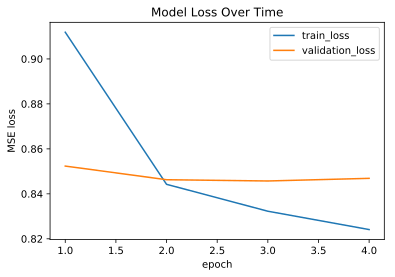

In [57]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'])
ax.plot(losses['epoch'], losses['validation_loss'])
ax.set_ylabel('MSE loss')
ax.set_xlabel('epoch')
ax.set_title('Model Loss Over Time')
ax.legend()

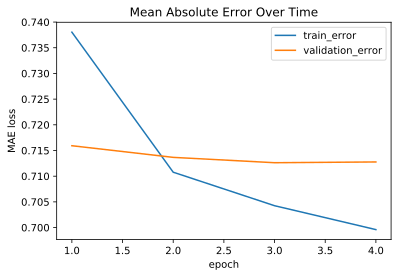

In [58]:
%config InlineBackend.figure_format = 'svg'
fig, ax = plt.subplots()
ax.plot(errors['epoch'], errors['train_error'])
ax.plot(errors['epoch'], errors['validation_error'])
ax.set_ylabel('MAE loss')
ax.set_xlabel('epoch')
ax.set_title('Mean Absolute Error Over Time')
ax.legend()

## Testing

In [49]:
def getItem(itemlist):
    return np.array([[item] for item in itemlist])

def predictRating(userId, movieId):
    return rec_model.predict(([np.array([userId]), np.array([movieId])]))[0][0]

def topPredictions(userId, rating_data, movie_data):
    userRatings = rating_data[rating_data['userId'] == userId][['userId', 'movieId', 'rating']]
    userRatings['prediction'] = userRatings.apply(lambda x: predictRating(userId, int(x['movieId'])), axis=1)
    return userRatings.sort_values(by='prediction', 
                         ascending=False).merge(movie_data, 
                                                on='movieId', 
                                                how='inner',
                                               suffixes = ['_u', '_m']).head(20)                                       

In [50]:
predictions = rec_model.predict([getItem(test['userId']), getItem(test['movieId'])])
print("MSE for test data :", mean_squared_error(test["rating"], predictions))

MSE for test data : 0.8459096385956427


## Predict Rating by User with ID X for Movie with ID Y

In [64]:
predictRating(3, 31) 

3.6021574

## Get Top 20 Predictions for a User ID based on his ratings

In [66]:
topPredictions(1,rating_data,movie_data)

,userId,movieId,rating,prediction,title,genres
0,1,4993,5.0,4.527629,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1,1,7153,5.0,4.516778,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
2,1,5952,5.0,4.464870,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
3,1,1196,4.5,4.249328,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
4,1,541,4.0,4.208074,Blade Runner (1982),Action|Sci-Fi|Thriller
5,1,3265,3.5,4.175037,Hard-Boiled (Lat sau san taam) (1992),Action|Crime|Drama|Thriller
6,1,293,4.0,4.140035,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
7,1,2628,4.0,4.102765,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
8,1,260,4.0,4.102588,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
9,1,8368,4.0,4.100841,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
